In [47]:
'''
Created on 05 November 2018
@author: skanneti

Binary classification: Predict if an asset will fail within certain time frame (e.g. cycles)

'''

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout, LSTM


# define a path to save model

model_path = '../../Output/binary_model.h5'


#############################################
# Data Ingestion
#############################################


# Reading training data - It is the aircraft engine run-to-failure data

train_df = pd.read_csv('../../Dataset/PM_train.txt', sep = " ", header = None)
train_df.drop(train_df.columns[[26, 27]], axis = 1, inplace = True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id', 'cycle'])

# read the test data - It is the aircraft engine operating data without failure events recorded

test_df = pd.read_csv('../../Dataset/PM_test.txt', sep = " ", header = None)
test_df.drop(test_df.columns[[26, 27]], axis = 1, inplace = True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
# read the ground truth data - It contains the information of true remaining cycles for each engine in teh testing data

truth_df = pd.read_csv('../../Dataset/PM_truth.txt', sep = " ", header = None)
truth_df.drop(truth_df.columns[[1]], axis = 1, inplace = True)

##############################################
# Data Preprocessing
##############################################


#############
# TRAIN
#############

# Data Labeling - generate column RUL (Remaining Useful Life or TIme to failure )

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on = ['id'], how = 'left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis = 1, inplace =True)

# generate label columns for training data
# We will only make use of label 1 for binary classification,
# While trying to answer the question: is a specific engine going to fail within w1 cycles ?

w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2


# MinMax Normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                            columns = cols_normalize, 
                            index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [51]:
# We use the ground truth dataset to generate labels for the test data.
# Generate column max for test data

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis = 1, inplace = True)

In [52]:
# Generate RUL for test data
test_df = test_df.merge(truth_df, on = ['id'], how = 'left' )
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis = 1, inplace = True)

In [53]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [57]:
############################################
# LSTM
############################################

# Pick a large window of size of 50 cycles
sequence_length = 50

# Function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """
    Only sequences that meet the window length are considered, no padding is used. This means for testing 
    we need to drop those which are below the below window length. An alternative would be to pad sequences 
    so that  we can use shorter ones
    """
    # For one id I put all the rows in a single matrix
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence length is equal to 50
    # So zip iterate over two following list of numbers (0, 112), (50, 192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
        
#pick the feature columns
    
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)
    
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols ))
          for id in train_df['id'].unique())

# Generate sequence and convert to numpy array

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# Function to generate labels

def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # .
    # [2000]]
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # Because for one id the first sequence of seq_length size have as target
    #  the last label ( the previous ones are discarder)
    # All the next id's sequences will have associated step by step one label as target
    
    return data_matrix[seq_length:num_elements, :]

# Generate labels

label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1'])
            for id in train_df['id'].unique()]


In [62]:
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [63]:
# Next we build a deep network
# The first layer is an LSTM layer with 100 units followed by another layer with 50 units
# Dropout is applied after each layer to control overfitting
# Final layer is a dense output layer with one single unit and sigmoid activation since binary classification problem

In [73]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [76]:
model = Sequential()

In [77]:
model.add(LSTM(input_shape = (sequence_length, nb_features),
              units = 100,
              return_sequences = True))

In [78]:
model.add(Dropout(0.2))

In [79]:
model.add(LSTM(units = 50,
               return_sequences = False))

In [80]:
model.add(Dropout(0.2))

model.add(Dense(units = nb_out, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [81]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
# Fit the network
history = model.fit(seq_array, label_array, epochs = 100, batch_size = 200, validation_split = 0.05, verbose = 2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                   )

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 33s - loss: 0.2778 - acc: 0.8790 - val_loss: 0.1190 - val_acc: 0.9655
Epoch 2/100
 - 29s - loss: 0.1032 - acc: 0.9583 - val_loss: 0.0710 - val_acc: 0.9693
Epoch 3/100
 - 29s - loss: 0.0866 - acc: 0.9653 - val_loss: 0.0653 - val_acc: 0.9680
Epoch 4/100
 - 29s - loss: 0.0750 - acc: 0.9686 - val_loss: 0.0418 - val_acc: 0.9834
Epoch 5/100
 - 30s - loss: 0.0671 - acc: 0.9734 - val_loss: 0.0420 - val_acc: 0.9808
Epoch 6/100
 - 29s - loss: 0.0606 - acc: 0.9747 - val_loss: 0.0337 - val_acc: 0.9872
Epoch 7/100
 - 29s - loss: 0.0604 - acc: 0.9743 - val_loss: 0.0495 - val_acc: 0.9770
Epoch 8/100
 - 29s - loss: 0.0669 - acc: 0.9729 - val_loss: 0.0696 - val_acc: 0.9655
Epoch 9/100
 - 29s - loss: 0.0580 - acc: 0.9758 - val_loss: 0.0434 - val_acc: 0.9808
Epoch 10/100
 - 29s - loss: 0.0633 - acc: 0.9744 - val_loss: 0.0540 - val_acc: 0.9719
Epoch 11/100
 - 30s - loss: 0.0610 - acc: 0.9759 - val_loss: 0.0556 - val_acc: 0.9757
Epoch 12/100
 -

In [83]:
# List all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


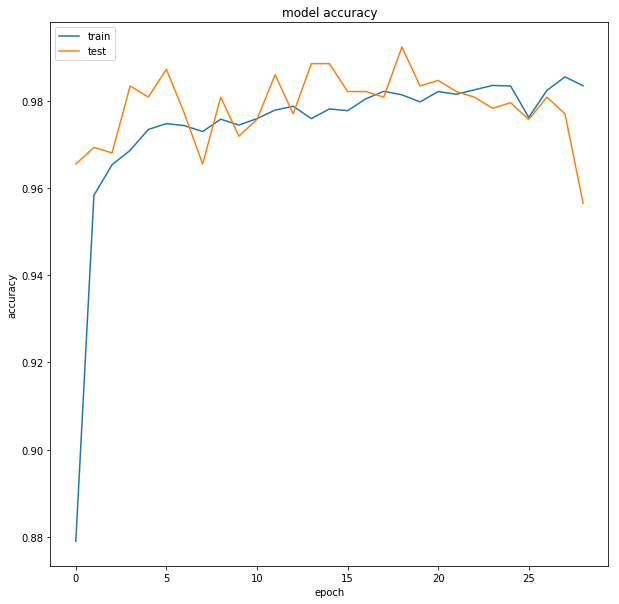

In [84]:
# Summarize hostory for accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../../Output/model_accuracy.png")

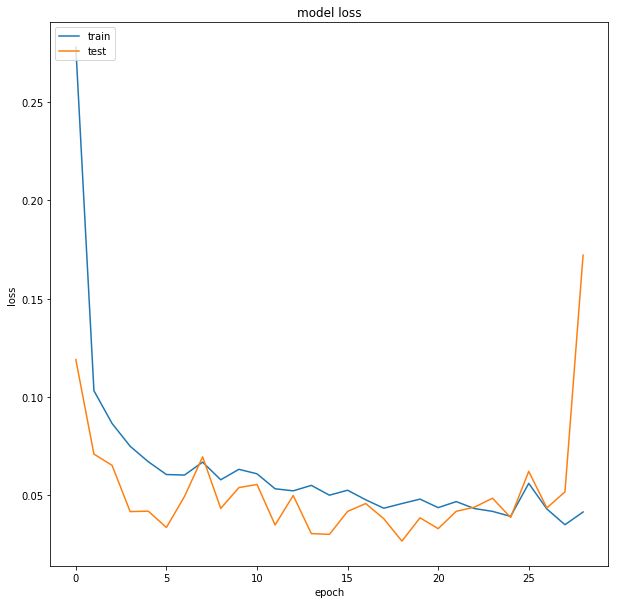

In [85]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../../Output/model_loss.png")

In [90]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('../../Output/binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last)
print(seq_array_test_last.shape)

15631/15631 [==============================] - 8s 488us/step
Accurracy: 0.9643017101574597
15631/15631 [==============================] - 8s 489us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12216   315]
 [  243  2857]]
precision =  0.9006935687263556 
 recall =  0.9216129032258065
seq_array_test_last
[[[0.3505747  0.8333333  0.         ... 0.         0.4728682  0.45457056]
  [0.39655173 0.5833333  0.         ... 0.         0.6511628  0.5608948 ]
  [0.5114943  0.25       0.         ... 0.         0.6356589  0.4975145 ]
  ...
  [0.43678162 0.75       0.         ... 0.         0.41860464 0.4710025 ]
  [0.5804598  0.6666667  0.         ... 0.         0.3255814  0.45954156]
  [0.40804598 0.8333333  0.         ... 0.         0.6124031  0.52444077]]

 [[0.55172414 0.25       0.         ... 0.         0.5503876  0.6974593 ]
  [0.39655173 0.5833333  0.         ... 0.         0.37209302 0.59748685]
  [0.5344828  0.16666667 0.         ... 0.         0.51937985 0

y_mask
[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(93, 1)
label_array_test_last
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 

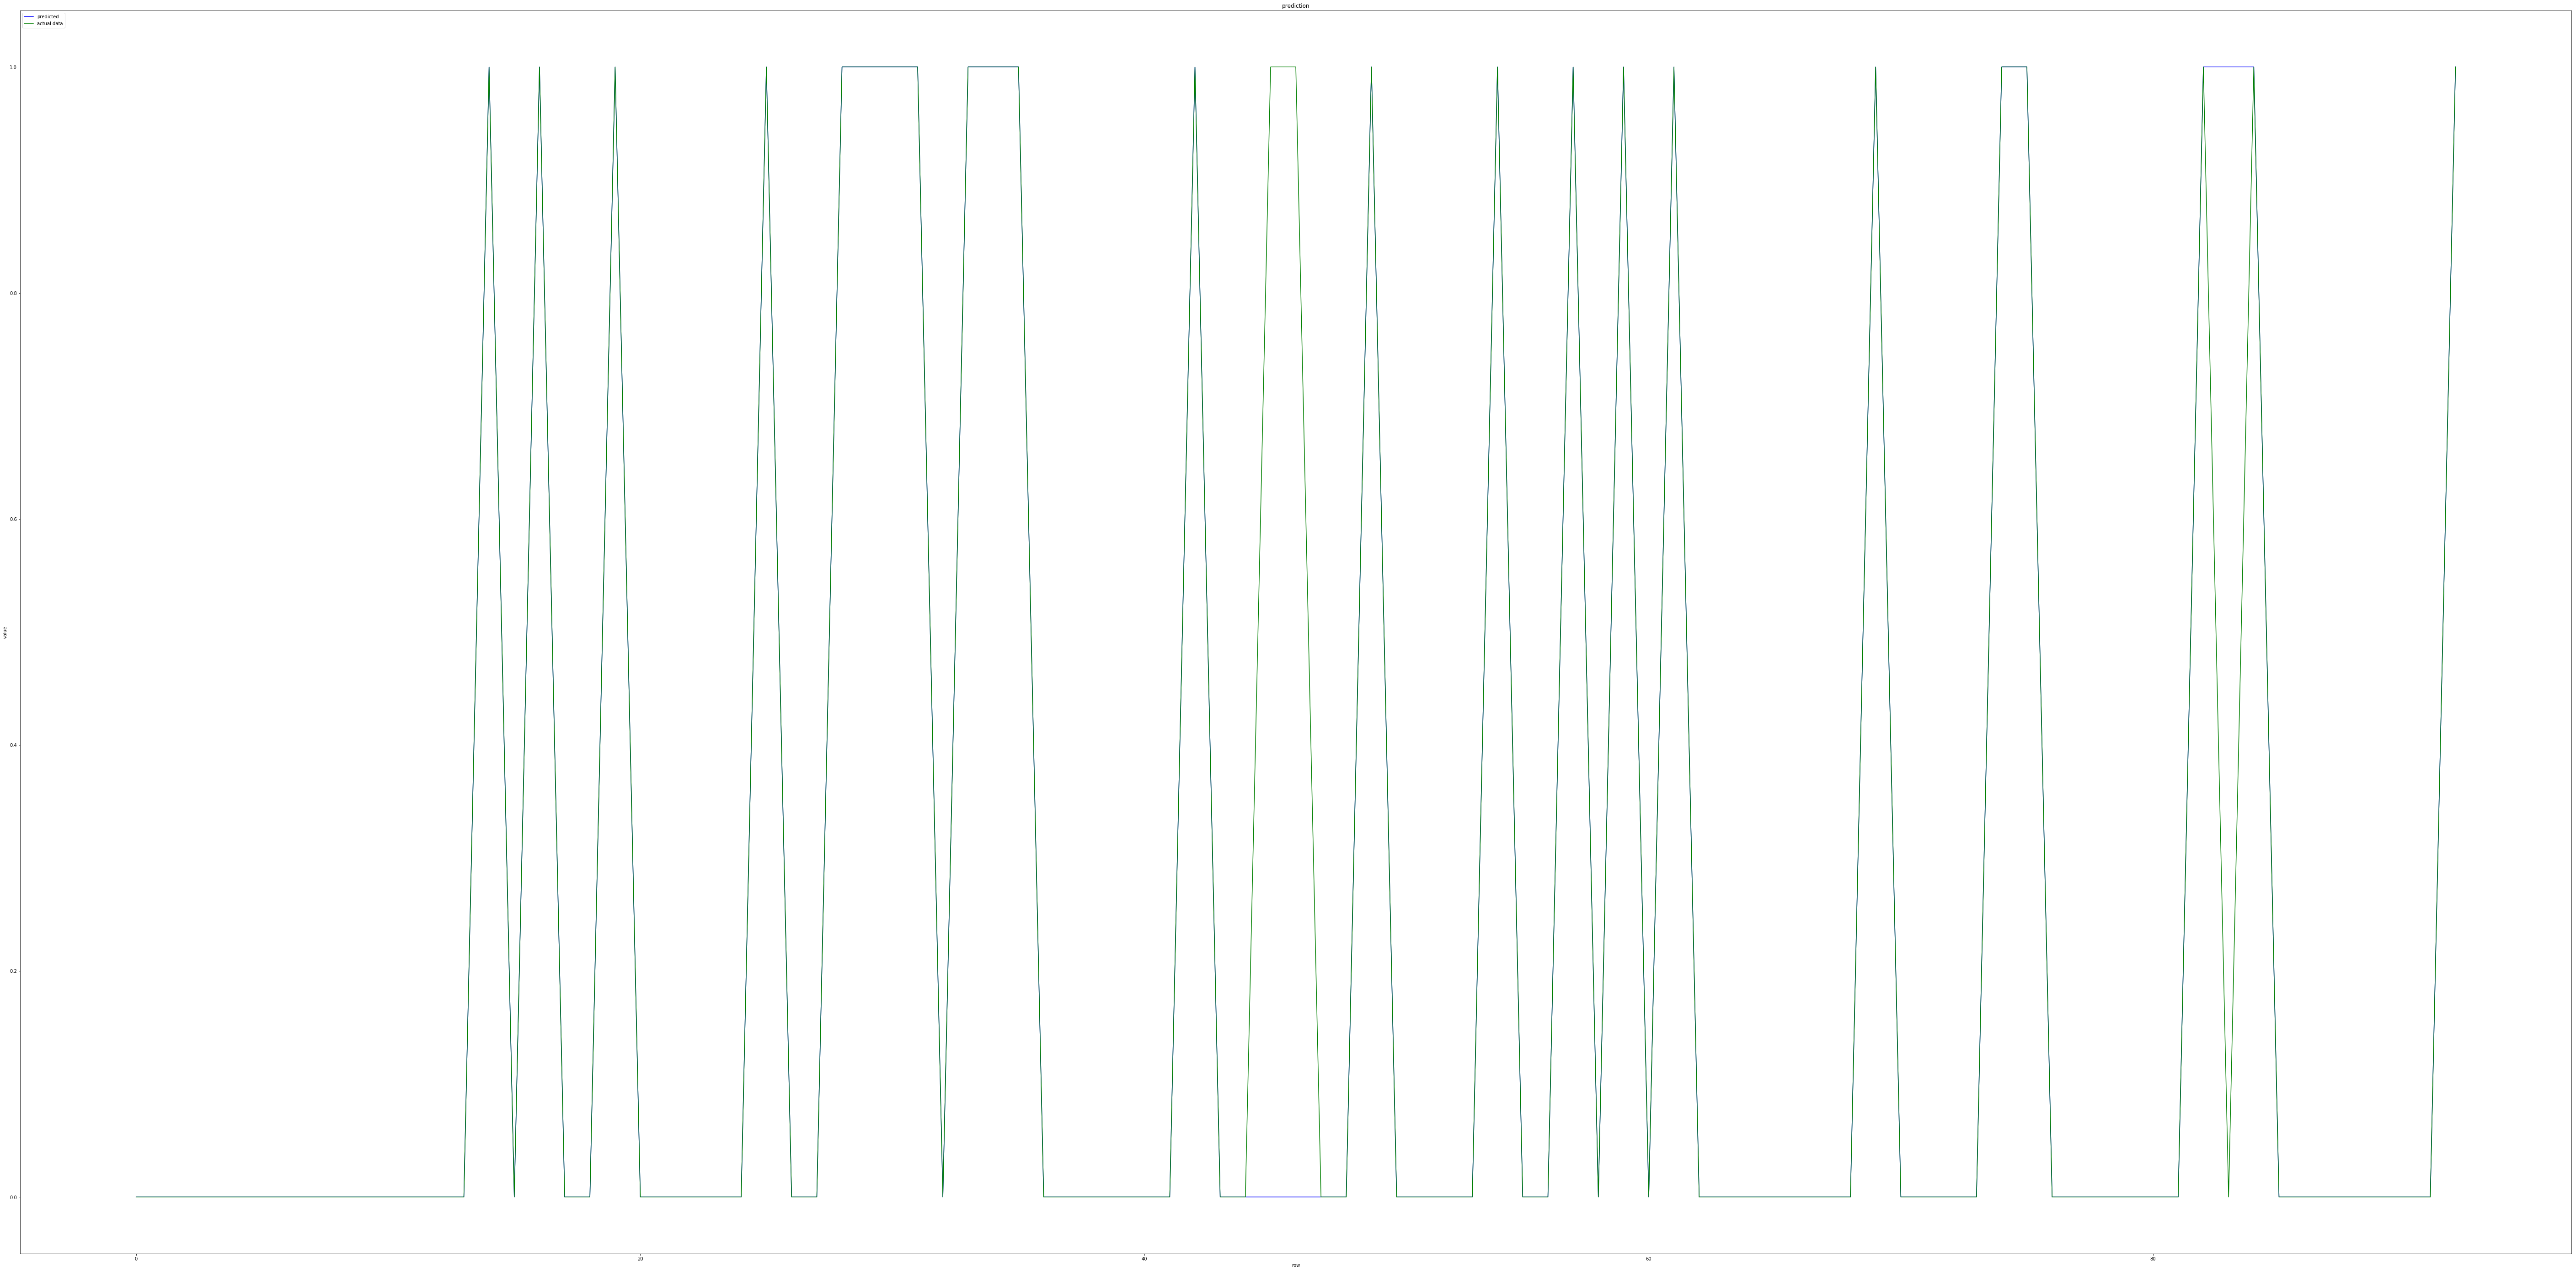

In [91]:
# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print("y_mask")
print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('../../Output/binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("../../Output/model_verify.png")